In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import os, sys
import matplotlib

CURRENT_DIR = os.getcwd()
module_path = os.path.abspath(os.path.join(CURRENT_DIR, "../.."))
if module_path not in sys.path:
    sys.path.append(module_path)

from transferring_transferability.GNN.model import GNN
from transferring_transferability.GNN import color_dict, plot_model_names
from transferring_transferability import typesetting, plot_dir

typesetting()

In [2]:
# gaussian feature, bernoulli ER graph
torch.manual_seed(10)


def generate_ER(N, n):
    p = 1 / 2
    adj_matrix = np.random.binomial(1, p, (N, n, n))
    adj_matrix = np.triu(adj_matrix, 0) + np.triu(adj_matrix, 1).transpose(0, 2, 1)
    x = np.ones((N, n, 1))
    return adj_matrix, x


def generate_constant_graphon(N, n):
    adj_matrix = np.ones((N, n, n), dtype=np.float32) * 1 / 2
    adj_matrix = np.triu(adj_matrix, 0) + np.triu(adj_matrix, 1).transpose(0, 2, 1)
    x = np.ones((N, n, 1))
    return adj_matrix, x


n_samples = 100
log_n_range = np.arange(1, 3, 0.2)
# for _ in range(5):
# fix 3 models with random weights
gnn_simple = GNN(channel_list=[1, 1], model="simple")
ptwise_compatible = GNN(
    channel_list=[1, 1],
    model="ign_anydim",
)
ptwise_incompatible = GNN(channel_list=[1, 5, 5, 1], model="ign")
gnn_reduced = GNN(channel_list=[1, 5, 5, 1], model="reduced")
gnn_unreduced = GNN(channel_list=[1, 5, 5, 1], model="unreduced")

# compute output
n_range = np.power(10, log_n_range).astype(int)
print(n_range)
models = {
    "GNN": gnn_simple,
    "IGN": ptwise_incompatible,
    "GGNN": gnn_unreduced,
    "Continuous GGNN": gnn_reduced,
}
outputs_ER = {}
outputs_constant = {}
for model_name, model in models.items():
    model.eval()
    outputs_ER.setdefault(model_name, [])
    outputs_constant.setdefault(model_name, [])
    for i, n in enumerate(n_range):
        A_ER, X_ER = generate_ER(n_samples, n)
        A_constant, X_constant = generate_constant_graphon(n_samples, n)
        with torch.no_grad():
            output_ER = model(torch.Tensor(A_ER), torch.Tensor(X_ER))
            output_constant = model(torch.Tensor(A_constant), torch.Tensor(X_constant))
            outputs_ER[model_name].append(output_ER)
            outputs_constant[model_name].append(output_constant)

[ 10  15  25  39  63  99 158 251 398 630]


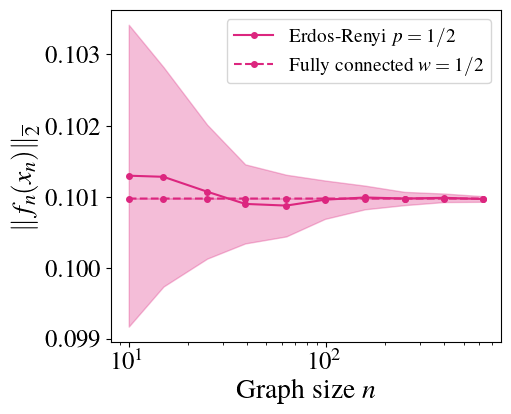

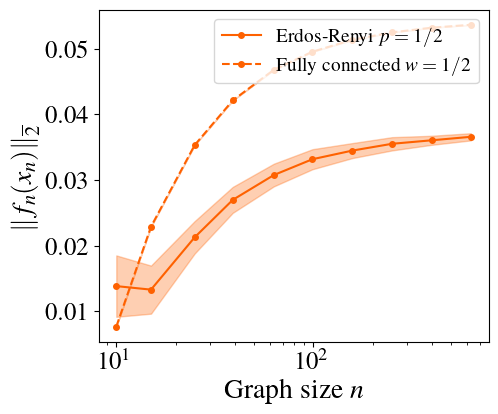

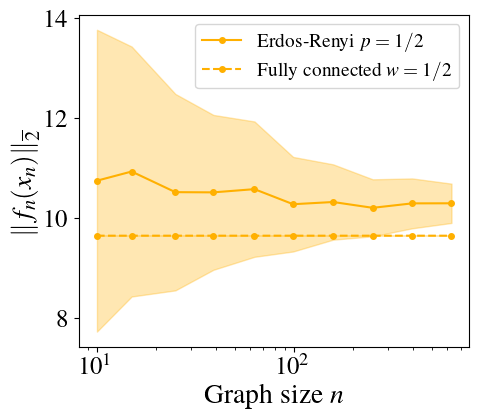

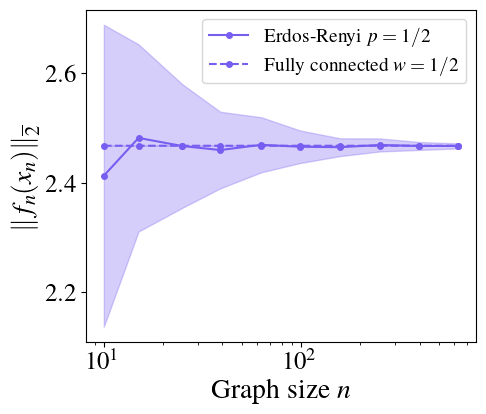

In [3]:
axes_rect = [0.21, 0.16, 0.78, 0.83]
for model_name, color in color_dict.items():
    fig = plt.figure(figsize=(5, 4))
    ax = fig.add_axes(axes_rect)

    # Precompute norms for ER and constant graphs
    norms_of_outputs_ER = [
        torch.norm(outputs_ER[model_name][i].squeeze(), dim=-1) / np.sqrt(n)
        for i, n in enumerate(n_range)
    ]
    norms_of_outputs_constant = [
        torch.norm(outputs_constant[model_name][i].squeeze(), dim=-1) / np.sqrt(n)
        for i, n in enumerate(n_range)
    ]

    # Compute means and stds for ER
    means_ER = [norm.mean() for norm in norms_of_outputs_ER]
    stds_ER = [norm.std() for norm in norms_of_outputs_ER]

    # Compute means and stds for constant
    means_constant = [norm.mean() for norm in norms_of_outputs_constant]
    stds_constant = [norm.std() for norm in norms_of_outputs_constant]

    # Plot ER graph
    ax.plot(
        n_range,
        means_ER,
        "o-",
        label=r"Erdos-Renyi $p=1/2$",
        color=color,
        markersize=4,
    )
    ax.fill_between(
        n_range,
        [mean - std for mean, std in zip(means_ER, stds_ER)],
        [mean + std for mean, std in zip(means_ER, stds_ER)],
        color=color,
        alpha=0.3,
    )

    # Plot constant graph
    ax.plot(
        n_range,
        means_constant,
        "o--",
        label=r"Fully connected $w=1/2$",
        color=color,
        markersize=4,
    )
    ax.fill_between(
        n_range,
        [mean - std for mean, std in zip(means_constant, stds_constant)],
        [mean + std for mean, std in zip(means_constant, stds_constant)],
        color=color,
        alpha=0.3,
    )

    # Set log scale and labels
    ax.set_xscale("log")
    ax.set_xlabel("Graph size $n$", fontsize=20)
    ax.set_ylabel(r"$\|f_n(x_n)\|_{\overline 2}$", fontsize=20)
    ax.legend(fontsize=14, loc="upper right")
    ax.tick_params(axis="both", which="major", labelsize=18)

    # Save and show the plot
    # plt.savefig(plot_dir / f"{model_name.lower().replace(' ', '_')}_transferability_outputs.png")
    plt.savefig(plot_dir / f"{model_name.lower().replace(' ', '_')}_transferability_outputs.pdf")
    plt.show()